In [1]:
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import os
from collections import Counter
from tqdm import tqdm
import pandas as pd

! pip install pymystem3==0.1.10
from pymystem3 import mystem
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

  Attempting uninstall: pymystem3
    Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Web-scraping

In [ ]:
#вспомогательная функция чтобы из неудобного ссупа без специальных тегов достать скор если он есть
def get_score(soup):
  s = soup.text
  if 'из 10' in s:
    score = int(s[s.find('из 10')-2])
    if score == 0:
      return 10
    return score
  else:
    return None

#функция, возвращающая суп по урлу
def get_soup(url):
  headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.1.2 Safari/605.1.15"}
  response = requests.get(url, headers=headers)
  response.encoding = response.apparent_encoding
  soup = BeautifulSoup(response.text)
  return soup

#функция, чтобы получить все зрительнские отзывы на один фильм и их скоры (тут все сразу записывается в файл)
def get_film_reviews(url, filename='reviews.txt'):
  soup = get_soup(url)
  reviews_container = soup.find_all('div', {'class': 'jr-user-reviews jrUserReviewsContainer'})[0]
  scores = [get_score(item) for item in reviews_container.find_all('div', {'class':'ReviewInfo'})]
  reviews = [item.text.replace('\n', ' ').replace('\r', ' ') for item in reviews_container.find_all('div', {'class':'jrReviewContent'})]
  reviews, scores = [reviews[i] for i in range(len(reviews)) if scores[i]], [scores[i] for i in range(len(reviews)) if scores[i]]
  with open(filename, 'a') as outfile:
    for i in range(len(reviews)):
      outfile.write(str(scores[i])+'\n')
      outfile.write(reviews[i]+'\n')

#функция, которая находит на главной странице ссылки на фильмы, у которых есть хотя бы один отзыв
def to_scrape(url):
  soup = get_soup(url)
  film_units = soup.find_all('div', {'class':'jrCardContent fwd-flex fwd-flex-col fwd-w-full fwd-h-full fwd-min-w-0'})
  links = [f.find('a') for f in film_units]
  ratings = [f.find('div', {'class':'jrOverallUser'}).text.replace('\xa0', '')[:3] for f in film_units]
  ratings = [True if len(r)>0 else False for r in ratings]
  return ['https://www.megacritic.ru'+links[i]['href'] for i in range(len(links)) if ratings[i]]

#функиця, которая собирает вссе ссылки на фильмы с помошью предыдущей с n_pages начиная со starting_page
def get_links(url_prefix='https://www.megacritic.ru/novye/filmy?page=', n_pages=0, starting_page=1):
  film_links = []
  for i in range(starting_page, starting_page+ n_pages):
    url = url_prefix + str(i)
    film_links.extend(to_scrape(url))
  return film_links

#функиця, котрая позволяет собрать и записать в файл filename отзывы с n_pages начиная со starting_page
def get_reviews(url_prefix='https://www.megacritic.ru/novye/filmy?page=', n_pages=0, starting_page=1, filename='reviews.txt'):
  os.remove(filename)
  film_links = get_links(n_pages=n_pages, starting_page=starting_page)
  for url in film_links:
    get_film_reviews(url, filename=filename)
  print('all done!')

Используем последнюю функцию выше и получаем файл отзывов

In [ ]:
get_reviews(n_pages=30, starting_page=1)

all done!


## Обработка

Считываем получившийся файл, разделяем отзывы и их скоры

In [53]:
with open('reviews.txt', 'r') as f:
  text = f.read().splitlines() 
scores = np.array(list(map(int, text[::2])))
reviews = text[1::2]

Приводим слова тексты к нижнему регистру, лемматизируем и очищаем от стоп-слов.

In [4]:
m = mystem.Mystem()
sw = stopwords.words('russian')

def preprocess(text, sw=sw, m=m):
  sents = sent_tokenize(text)
  words = sum([[w for w in m.lemmatize(sent.lower()) if w.isalpha() and w not in sw] for sent in sents], [])
  words = [w for w in words if len(w)>1]
  return words

corpus = np.array([preprocess(r) for r in reviews], dtype=object)

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [6]:
from tqdm import tqdm
corpus = []
for i in tqdm(range(len(reviews))):
  corpus.append(preprocess(reviews[i]))
corpus = np.array(corpus, dtype=object)

100%|██████████| 2470/2470 [00:09<00:00, 273.07it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [7]:
X_train, X_test, y_train, y_test = train_test_split(corpus, scores, test_size=0.33, random_state=42)

## Множества положительных и отрицательных слов

Получим множества слов в положительных и отрицательных отзывах. Но, для того чтобы набор был более "говорящим",делить будем не пополам -- введем пороги для того что мы будем считать положительными и отрицательными отзывами. 

(array([544., 155., 207., 141., 160., 159., 184., 254., 198., 468.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

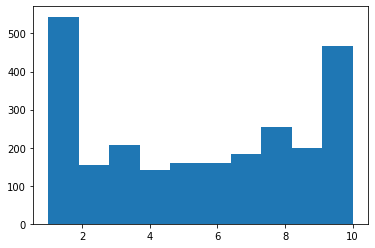

In [8]:
plt.hist(scores)

In [9]:
#функция, котрая позволяет получать сеты слов из положительных и отрицательных отзывов,
#можно изменять порог скора для положительных и отрицательных отзывов и порог частотности, меньше которой слова отрезаются
def get_sets(corpus, scores, positive_score_thr = 7, neagtive_score_thr = 4, counter_thr=0):
  positive_mask = np.where(scores>positive_score_thr)[0]
  negative_mask = np.where(scores<neagtive_score_thr)[0]
  
  pos_counter = Counter(corpus[positive_mask].sum())
  pos_list = {k:v for k,v in pos_counter.items() if v>counter_thr}
  neg_counter = Counter(corpus[negative_mask].sum())
  neg_list = {k:v for k,v in neg_counter.items() if v>counter_thr}

  pos_set = set(pos_list) - set(neg_list)
  neg_set = set(neg_list) - set(pos_list)
  return pos_set, neg_set

## Cамый незамысловатый способ решения

In [20]:
# 0 = negative
# 1 = neutral
# 2 = positive

def map_scores(scores, positive_score_thr = 6, neagtive_score_thr = 5):
  dictionary = {}
  for i in range(1,11):
    if i < neagtive_score_thr:
      dictionary[i] = 0
    elif i <= positive_score_thr:
      dictionary[i] = 1
    else:
      dictionary[i] = 2
  return np.array(list(map(dictionary.get, scores)))

def stupid_predict(x, pos_set, neg_set):
  pos_q, neg_q = 0, 0
  for word in x:
    if word in pos_set:
      pos_q +=1
    elif word in neg_set:
      neg_q +=1
  if pos_q>neg_q:
    return 2
  elif pos_q<neg_q:
    return 0
  else:
    return 1

In [23]:
from sklearn.metrics import accuracy_score

def compute_stupid_predict_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = 6, neagtive_score_thr = 5, counter_thr=0):
  pos_set, neg_set = get_sets(X_train, y_train, positive_score_thr = positive_score_thr, 
                              neagtive_score_thr = neagtive_score_thr, counter_thr=counter_thr)
  y_test_mapped = map_scores(y_test, positive_score_thr = positive_score_thr, neagtive_score_thr = neagtive_score_thr)
  y_pred = np.array([stupid_predict(X_test[i], pos_set, neg_set) for i in range(len(X_test))])
  return accuracy_score(y_test_mapped, y_pred)

In [30]:
test_scores = {}
for pst, nst in zip([6,7,8,9], [5,4,3,2]):
  key = 'pst = {}, nst = {}'.format(pst,nst)
  test_scores[key] = []
  for thr in [0,1,2,3,4,5]:
    test_scores[key].append(compute_stupid_predict_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = pst, neagtive_score_thr = nst, counter_thr=thr))
    
pd.DataFrame(test_scores)

,"pst = 6, nst = 5","pst = 7, nst = 4","pst = 8, nst = 3","pst = 9, nst = 2"
0,0.544118,0.503676,0.441176,0.376225
1,0.553922,0.523284,0.490196,0.404412
2,0.585784,0.578431,0.504902,0.425245
3,0.616422,0.580882,0.514706,0.403186
4,0.629902,0.578431,0.509804,0.404412
5,0.621324,0.604167,0.506127,0.424020


Лучший результат на новых данных показывает "модель" с делением отзывы на отрицательные < 5 и положительные > 6 с порогом словаря 4 -- 63%.  Посмотрим на ее словари:

In [33]:
pos_set, neg_set = get_sets(X_train, y_train, positive_score_thr = 6, 
                              neagtive_score_thr = 5, counter_thr=4)
pd.DataFrame({'pos':list(pos_set)[:20], 'neg':list(neg_set)[:20]})

,pos,neg
0,прекрасно,тупость
1,рецензия,позор
2,квин,поступок
3,приличный,вебой
4,одновременно,явный
5,фишка,кадры
6,предыдущий,кошмар
7,дурак,форма
8,продумывать,видео
9,трагедия,уважаемый


## Улучшения


### Словам можно дать веса
Проще всего получить те же самые множества слов, встречающихся только в положительных или только отрицательных множествах, но дать им веса в зависимости от того, насколько часто они встречаются в таких отзывах. В предикте вместо сравнения количества тех или иных слов складывать веса.

In [46]:
def get_counters(corpus, scores, positive_score_thr = 7, neagtive_score_thr = 4, counter_thr=0):
  positive_mask = np.where(scores>positive_score_thr)[0]
  negative_mask = np.where(scores<neagtive_score_thr)[0]
  
  pos_counter = Counter(corpus[positive_mask].sum())
  pos_unique = list(pos_counter)
  neg_counter = Counter(corpus[negative_mask].sum())
  neg_unique = list(neg_counter)
  
  pos_list = {k:v for k,v in pos_counter.items() if v>counter_thr and k not in neg_unique}
  neg_list = {k:v for k,v in neg_counter.items() if v>counter_thr and k not in pos_unique}
  return pos_list, neg_list

def slightly_smarter_predict(x, pos_counter, neg_counter):
  pos_sum, neg_sum = 0, 0
  pos, neg = list(pos_counter.keys()), list(neg_counter.keys())
  for word in x:
    if word in pos:
      pos_sum += pos_counter[word]
    elif word in neg:
      neg_sum += neg_counter[word]
  if pos_sum>neg_sum:
    return 2
  elif pos_sum<neg_sum:
    return 0
  else:
    return 1

def compute_slightly_smarter_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = 6, neagtive_score_thr = 5, counter_thr=0):
  pos_counter, neg_counter = get_counters(X_train, y_train, positive_score_thr = positive_score_thr, 
                              neagtive_score_thr = neagtive_score_thr, counter_thr=counter_thr)
  y_test_mapped = map_scores(y_test, positive_score_thr = positive_score_thr, neagtive_score_thr = neagtive_score_thr)
  y_pred = np.array([slightly_smarter_predict(X_test[i], pos_counter, neg_counter) for i in range(len(X_test))])
  return accuracy_score(y_test_mapped, y_pred)

In [41]:
pos_counter, neg_counter = get_counters(X_train, y_train, positive_score_thr = 7, 
                              neagtive_score_thr = 4, counter_thr=3)
y_mapped = map_scores(y_test, positive_score_thr = 7, neagtive_score_thr = 4)

In [47]:
test_scores = {}
for pst, nst in zip([6,7,8,9], [5,4,3,2]):
  key = 'pst = {}, nst = {}'.format(pst,nst)
  test_scores[key] = []
  for thr in [0,1,2,3,4,5]:
    test_scores[key].append(compute_slightly_smarter_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = pst, neagtive_score_thr = nst, counter_thr=thr))
    
pd.DataFrame(test_scores)

,"pst = 6, nst = 5","pst = 7, nst = 4","pst = 8, nst = 3","pst = 9, nst = 2"
0,0.568627,0.535539,0.452206,0.366422
1,0.514706,0.495098,0.452206,0.368873
2,0.458333,0.480392,0.453431,0.432598
3,0.421569,0.464461,0.466912,0.464461
4,0.373775,0.425245,0.479167,0.492647
5,0.329657,0.401961,0.469363,0.493873


Итог: :/// получилось хуже
Как это можно исправить: вместо того чтобы считать веса плохости (по возрастанию) и хорошести (тоже по возрастанию), можно сделать одну шкалу, не деля слова -- взять все слова и по тому, насколько часто они входили в плохие или хорошие отзывы дать им вес: чем меньше, тем слово "хуже", чем больше -- тем "лучше".
<br/>
А пока я хочу попробовать немного другую идею. 

### N-граммы
"Полное наслаждение" и "полное разочарование" -- разные вещи.
Переделаем словарь и воспользуемся старыми функциями для предсказания и оценки. Посмотрим на биграммы.

In [72]:
def get_bigram_corpus(corpus):
  return np.array([[' '.join([doc[i], doc[i+1]]) for i in range(len(doc)-1)] for doc in corpus],dtype=object)

bigram_corpus = get_bigram_corpus(corpus)
X_train, X_test, y_train, y_test = train_test_split(bigram_corpus, scores, test_size=0.33, random_state=42)

In [65]:
test_scores = {}
for pst, nst in zip([6,7,8,9], [5,4,3,2]):
  key = 'pst = {}, nst = {}'.format(pst,nst)
  test_scores[key] = []
  for thr in [0,1,2,3,4,5]:
    test_scores[key].append(compute_stupid_predict_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = pst, neagtive_score_thr = nst, counter_thr=thr))
    
pd.DataFrame(test_scores)

,"pst = 6, nst = 5","pst = 7, nst = 4","pst = 8, nst = 3","pst = 9, nst = 2"
0,0.609069,0.582108,0.479167,0.421569
1,0.552696,0.530637,0.481618,0.464461
2,0.502451,0.517157,0.487745,0.500000
3,0.484069,0.486520,0.507353,0.509804
4,0.466912,0.460784,0.498775,0.496324
5,0.432598,0.452206,0.484069,0.504902


In [66]:
test_scores = {}
for pst, nst in zip([6,7,8,9], [5,4,3,2]):
  key = 'pst = {}, nst = {}'.format(pst,nst)
  test_scores[key] = []
  for thr in [0,1,2,3,4,5]:
    test_scores[key].append(compute_slightly_smarter_metric(X_train, X_test, y_train, y_test, 
                                  positive_score_thr = pst, neagtive_score_thr = nst, counter_thr=thr))
    
pd.DataFrame(test_scores)

,"pst = 6, nst = 5","pst = 7, nst = 4","pst = 8, nst = 3","pst = 9, nst = 2"
0,0.636029,0.604167,0.475490,0.395833
1,0.517157,0.526961,0.500000,0.479167
2,0.412990,0.474265,0.501225,0.556373
3,0.351716,0.428922,0.512255,0.594363
4,0.305147,0.401961,0.513480,0.598039
5,0.256127,0.365196,0.512255,0.595588


Совмещением первой идеи и биграмм получилось побить самый простой способ на 0,6% 🥲

### ML 
1. Векторизовать тексты с помощью count_vectorizer'а и построить какую-нибудь модель, например Support Vector Machine
2. можно еще на tf-idf

In [85]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
count_vec = vectorizer.fit_transform(corpus)
scores = map_scores(scores, positive_score_thr = 7, neagtive_score_thr = 4)
X_train, X_test, y_train, y_test = train_test_split(count_vec, scores, test_size=0.33, random_state=42)

In [88]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.6899509803921569
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       308
           1       0.54      0.47      0.50       200
           2       0.68      0.81      0.74       308

    accuracy                           0.69       816
   macro avg       0.67      0.66      0.67       816
weighted avg       0.69      0.69      0.69       816



In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
X_train, X_test, y_train, y_test = train_test_split(corpus, scores, test_size=0.33, random_state=42)

#Обучаем векторизатор только на обучающей выборке, затем используем получемнные idf для трансформации тестовой
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [95]:
sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.7377450980392157
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       308
           1       0.70      0.37      0.48       200
           2       0.75      0.84      0.79       308

    accuracy                           0.74       816
   macro avg       0.73      0.69      0.69       816
weighted avg       0.73      0.74      0.72       816



Ура, тут получились резульаты получше :)